# 1.Understanding Problem Space

In [1]:
import pandas as pd
import numpy as np
#from io import BytesIO
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
#We charge the dataframes

abandoned_carts = pd.read_parquet("abandoned_carts.parquet")
inventory = pd.read_parquet("inventory.parquet")
orders = pd.read_parquet("orders.parquet")
regulars = pd.read_parquet("regulars.parquet")
users = pd.read_parquet("users.parquet")

In [3]:
#We start analysing abandoned_carts field by field.
#It is noticeable how the majority of the elements of the dataframe are missing (we have 
# 5000 out of 70000), so the ideas extracted have to be taken with a pinch of salt. 

print(abandoned_carts)

                   id                                            user_id  \
0      12858560217220  5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b...   
13     20352449839236  9d6187545c005d39e44d0456d87790db18611d7c7379bd...   
45     20478401413252  e83fb0273d70c37a2968fee107113698fd4f389c442c0b...   
50     20481783103620  10c42e10e530284b7c7c50f3a23a98726d5747b8128084...   
52     20485321687172  d9989439524b3f6fc4f41686d043f315fb408b954d6153...   
...               ...                                                ...   
70036  22233840976004  2e989bfdec87ef55ea464a529f323ff53dad2a2fc48655...   
70041  22233843171460  b2d867b982b14ca517f27c4ced727c8a25c01b96ebbd96...   
70043  22233843531908  220aafc0749f209b3f0f7cfe4134a5136815d48f0bbd9a...   
70049  22233846218884  a4da55d51052411e54f98e1b90b19843121866abeaea76...   
70050  22233846317188  c0e740ecabe7bd19eaed35b5ea9be7bc80c15f32124712...   

               created_at                                         variant_id  
0     20

In [5]:
#On a superficial level, there are no nulls, so we move forward

abandoned_carts.isnull().sum()

id            0
user_id       0
created_at    0
variant_id    0
dtype: int64

In [6]:
#abandoned_carts id: unique id value for each order / purchase. 

ac_id_unique = set(abandoned_carts["id"])
print(len(ac_id_unique)) #matches with rows read before

5457


In [7]:
#user id: unique id of the users that have abandoned a cart. 
#Column has duplicates, so some users have abandoned more than one cart. 

ac_user_id_unique = set(abandoned_carts["user_id"])
print(len(ac_user_id_unique))

3439


In [8]:
#Majority of users have abandoned 1 - 2 carts. The number of people abandoning carts reduces with the
#frequency; not many of them abandon from 5 carts onwards. 

ac_user_id = Counter(abandoned_carts["user_id"].tolist())
ac_number_peruser=[]
for key in ac_user_id:
    ac_number_peruser.append(ac_user_id[key])
ac_number_peruser=Counter(ac_number_peruser)
ac_number_peruser=dict(sorted(ac_number_peruser.items(), key=lambda item: item[1]))
print(ac_number_peruser)

{10: 1, 9: 1, 6: 6, 7: 8, 5: 23, 4: 51, 3: 238, 2: 1202, 1: 1909}


In [10]:
#created_at: when the basket was generated. We can perform some data aggrupations to see if there is
#a seasonality on the cancellations, or if they were done during one specific year.

created_at_date_separated = pd.DataFrame(columns=['Year','Month','Day','Hour'])
for element in abandoned_carts["created_at"]:
    created_at_date_separated.loc[len(created_at_date_separated)]={'Year': element.year, 'Month':element.month,'Day':element.day,'Hour':element.hour}
created_at_date_separated
    

,Year,Month,Day,Hour
0,2020,5,20,13
1,2021,6,27,5
2,2021,7,18,8
3,2021,7,18,21
4,2021,7,19,12
...,...,...,...,...
5452,2022,3,13,14
5453,2022,3,13,14
5454,2022,3,13,14
5455,2022,3,13,14


In [11]:
#Somehow, the majority of the cancellations are accummulated during autumn-winter, whereas in 
#spring - summer there are the lowest numbers.

print(created_at_date_separated.groupby(['Year','Month'])['Day'].count())


Year  Month
2020  5           1
2021  6           1
      7          25
      8         135
      9         248
      10        560
      11        988
      12        871
2022  1        1318
      2         989
      3         321
Name: Day, dtype: int64


<BarContainer object of 31 artists>

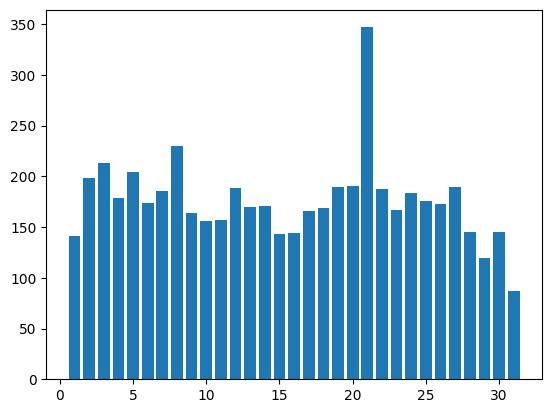

In [12]:
#Except maybe from outlier 21st, all of the days the cancellation rate is similar

plt.bar(range(1,32),created_at_date_separated.groupby(['Day'])['Month'].count())

<BarContainer object of 24 artists>

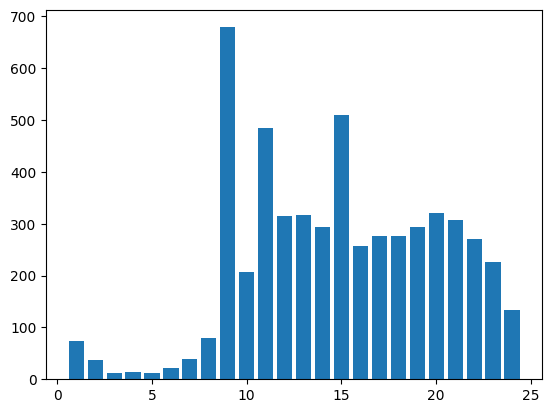

In [13]:
#The fact that not many baskets are cancelled at night implies how this service is not international,
#kind of restricted to limited timezones. The peak hours of cancellations are the standard ones: first
#thing in the morning (9.00), mid-morning (around 11.00) and first thing in the afternoon (15.00)

plt.bar(range(1,25),created_at_date_separated.groupby(['Hour'])['Month'].count())

In [14]:
#variant id: not entirely defined field by itself, but with inventory we discover that it is the id
#of the product in the basket

In [15]:
print(inventory)

          variant_id  price  compare_at_price          vendor  \
0     39587297165444   3.09              3.15           heinz   
1     34370361229444   4.99              5.50   whogivesacrap   
2     34284951863428   3.69              3.99          plenty   
3     33667283583108   1.79              1.99  thecheekypanda   
4     33803537973380   1.99              2.09         colgate   
...              ...    ...               ...             ...   
1728  39539419218052   4.99              5.99          bother   
1729  34534187368580   4.69              5.49    tommeetippee   
1730  33826439594116  15.39             17.15          colief   
1731  33667214508164  19.49             21.65      enterosgel   
1732  33667214704772  31.99             34.60         eskimo3   

                         product_type  \
0                condiments-dressings   
1     toilet-roll-kitchen-roll-tissue   
2     toilet-roll-kitchen-roll-tissue   
3     toilet-roll-kitchen-roll-tissue   
4             

In [16]:
#On a superficial level, there are no nulls, so we move forward

inventory.isnull().sum()

variant_id          0
price               0
compare_at_price    0
vendor              0
product_type        0
tags                0
dtype: int64

In [17]:
# variant_id: the id of the product of the basket. It is unique, so there are no errors 
inv_id_unique = set(inventory["variant_id"])
print(len(inv_id_unique)) 

1733


{'whiskers': [<matplotlib.lines.Line2D at 0x7f864ef2c210>,
 'caps': [<matplotlib.lines.Line2D at 0x7f864ef2d4d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f864c5e7cd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f864ef2e850>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f864ef2f090>],
 'means': []}

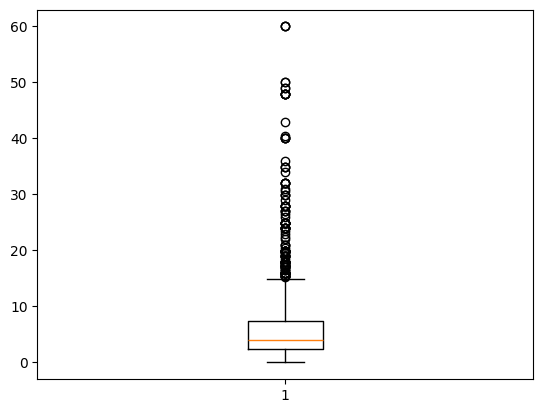

In [18]:
# price: the price of the product. In the boxplot, we see how the average price of all objects in
#the store is not a representative metric, as there are many outliers with high price. 

plt.boxplot(inventory["price"])

In [19]:
#In the end of the day, in a grocery store some things are generally cheap (food) and other more expensive 
#(household appliances, chemical products...). The best way is to represent the price by intervals.
#We see the info that the majority of products lie in the categories 0-2, 2-4, 4-6, which is the typical
#price for groceries and basic products. The amount of products from 20 euros onwards is basically marginal

price_intervals=((0,2),(2,4),(4,6),(6,8),(8,10),(10,12),(12,14),(14,16),(16,18),(18,20),(20,25),(25,30),(30,50),(50,70))
count_price_intervals={}
for interval in price_intervals:
    count_price_intervals[interval]=len(inventory["price"][(inventory["price"]>interval[0]) & (inventory["price"]<=interval[1])])
print(count_price_intervals)

{(0, 2): 270, (2, 4): 544, (4, 6): 341, (6, 8): 115, (8, 10): 105, (10, 12): 91, (12, 14): 33, (14, 16): 48, (16, 18): 25, (18, 20): 20, (20, 25): 24, (25, 30): 15, (30, 50): 28, (50, 70): 3}


{'whiskers': [<matplotlib.lines.Line2D at 0x7f864ef864d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f864ef87650>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f864ef85b10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f864ef9c890>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f864ef9d190>],
 'means': []}

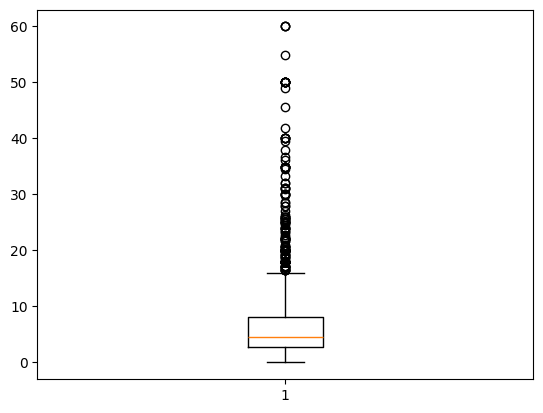

In [20]:
#compare_at_price: this value is a bit different, similar to price. 

plt.boxplot(inventory["compare_at_price"])

In [22]:
#It is not entirely clear what compare_at_price is, maybe it is the true price at which we sell, 
#and the price before is the raw price at what we buy, so we earn the difference. Maybe it is the difference
#of what we sell vs the price of our competitiors... For that, let' calculate the difference between these 
#2 columns.

#Some of these differences are negative, but most remain positive and low, between 0 - 1. 


substract_prices= inventory['compare_at_price'].sub(inventory['price'])
price_differences=((-0.6,-0.4),(-0.4,-0.2),(-0.2,0),(0,0.2),(0.2,0.4),(0.4,0.6),(0.6,0.8),(0.8,1),(1,2),(2,3),(4,6),(6,8),(8,10),(10,20),(20,30))
price_differences_intervals={}
for interval in price_differences:
    price_differences_intervals[interval]=((substract_prices>interval[0]) & (substract_prices<=interval[1])).sum()
print(price_differences_intervals)

{(-0.6, -0.4): 0, (-0.4, -0.2): 2, (-0.2, 0): 107, (0, 0.2): 710, (0.2, 0.4): 208, (0.4, 0.6): 183, (0.6, 0.8): 72, (0.8, 1): 76, (1, 2): 182, (2, 3): 89, (4, 6): 22, (6, 8): 9, (8, 10): 7, (10, 20): 2, (20, 30): 0}


In [23]:
#vendor: clearly represents the manufacturer. We see how biona, ecover, napolina... are the ones
#that sell the most amount of products, and some manufacturers only sell 1 product. In total, 412 brands
#are offered.
print(inventory['vendor'].value_counts())


vendor
biona              69
ecover             34
napolina           28
faithinnature      27
method             26
                   ..
betterbodyfoods     1
jameson             1
purato              1
kwv                 1
eskimo3             1
Name: count, Length: 412, dtype: int64


In [24]:
#product_type: represents the category of the product. With the same analysis as before, the majority
#of products are categorised as cleaning products. There are few relevant categories among the top ten, 
#including tin food, snacks, baby toddler food...

print(inventory['product_type'].value_counts())


product_type
cleaning-products                  160
tins-packaged-foods                125
snacks-confectionery               122
cooking-ingredients                 73
pasta-rice-noodles                  66
baby-toddler-food                   62
condiments-dressings                52
cereal                              51
haircare                            50
biscuits-crackers                   49
soft-drinks-mixers                  48
baby-kids-toiletries                45
skincare                            44
cooking-sauces                      43
dog-food                            42
dental                              42
baby-accessories                    41
superfoods-supplements              37
cat-food                            35
shaving-grooming                    29
nappies-nappy-pants                 29
dishwashing                         27
period-care                         26
home-baking                         25
hand-soap-sanitisers                24
long-life-mi

In [43]:
print(orders)

                  id                                            user_id  \
10     2204073066628  62e271062eb827e411bd73941178d29b022f5f2de9d37f...   
20     2204707520644  bf591c887c46d5d3513142b6a855dd7ffb9cc00697f6f5...   
21     2204838822020  329f08c66abb51f8c0b8a9526670da2d94c0c6eef06700...   
34     2208967852164  f6451fce7b1c58d0effbe37fcb4e67b718193562766470...   
49     2215889436804  68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...   
...              ...                                                ...   
64396  4026096910468  f524eaf26b76bc6226747768f120ffcd23d5c3d52a0a19...   
64488  4026464993412  aa5e21db3186dcd84c161719c5ade8a19adb853ea8bfef...   
64499  4026553434244  14be3833c19e0a1fd7e6db0e5375a3d1dcc9efafcb0e69...   
64523  4026656030852  500027bf392bfa9ef527919569fba44904d429155b7cf4...   
64538  4026732413060  faaad4bc113fe7e0a888a0d3535877d3c692f591882c25...   

               created_at order_date  user_order_seq  \
10    2020-04-30 14:32:19 2020-04-30       

In [28]:
#On a superficial level, there are no nulls, so we move forward.

orders.isnull().sum()

id                0
user_id           0
created_at        0
order_date        0
user_order_seq    0
ordered_items     0
dtype: int64

In [29]:
#We count the elements too. 
orders.count()

id                8773
user_id           8773
created_at        8773
order_date        8773
user_order_seq    8773
ordered_items     8773
dtype: int64

In [30]:
#id: should be the id of the purchase. It should have no duplicates if each order contains a basket of
#products

ord_id_unique = set(orders["id"])
print(len(ord_id_unique)) 

8773


In [32]:
#user_id: should be the id of the user. There should be duplicates if some particular user buys more than
#once, which is the case.

ord_user_id_unique = set(orders["user_id"])
print(len(ord_user_id_unique)) 

4983


In [38]:
#The difference is quite large, let´s delve deeper into this. In extreme cases, this can mean that at least
#every customer buys twice in our shop, or that some few customers can repeat a lot.
#Its interesting to check intervals of customers. The results show that an outstanding majority
#only shops once in our online store. We also have a solid, yet quite small, groups of people that buy
#recurrently (from 5 times onwards). 

user_id_counter=Counter(orders["user_id"])
people_repetition_intervals=(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25)
count_userid_intervals={"1":0,"2":0,"3":0,"4":0,"5":0,"6":0,"7-10":0,"11-15":0,"16+":0}
for element in dict(user_id_counter).values():
    if element<=6:
        count_userid_intervals[str(element)]+=1
    else: 
        match element:
            case 7|8|9|10:
                count_userid_intervals["7-10"]+=1
            case 1|12|13|14|15:
                count_userid_intervals["11-15"]+=1
            case _:
                count_userid_intervals["16+"]+=1
print(count_userid_intervals)

{'1': 3572, '2': 698, '3': 251, '4': 148, '5': 89, '6': 58, '7-10': 116, '11-15': 24, '16+': 27}


In [39]:
#created_at: when the basket was generated. We can perform the same analysis as with the cancellations case.

ord_created_at_date_separated = pd.DataFrame(columns=['Year','Month','Day','Hour'])
for element in orders["created_at"]:
    ord_created_at_date_separated.loc[len(ord_created_at_date_separated)]={'Year': element.year, 'Month':element.month,'Day':element.day,'Hour':element.hour}
ord_created_at_date_separated

,Year,Month,Day,Hour
0,2020,4,30,14
1,2020,4,30,17
2,2020,4,30,18
3,2020,5,1,19
4,2020,5,3,21
...,...,...,...,...
8768,2022,3,13,10
8769,2022,3,13,18
8770,2022,3,13,20
8771,2022,3,13,22


In [40]:
#We see that the store has generally been growing since its possible foundation in 2020. It is also 
#corroborated how most of the sales occur during autumn-winter, which is in line with having a larger
#number of basket cancellations. 

print(ord_created_at_date_separated.groupby(['Year','Month'])['Day'].count())

Year  Month
2020  4           3
      5          25
      6          42
      7          58
      8          66
      9          95
      10        124
      11        152
      12        175
2021  1         390
      2         374
      3         397
      4         391
      5         408
      6         412
      7         335
      8         345
      9         359
      10        754
      11        903
      12        716
2022  1        1080
      2         891
      3         278
Name: Day, dtype: int64


<BarContainer object of 31 artists>

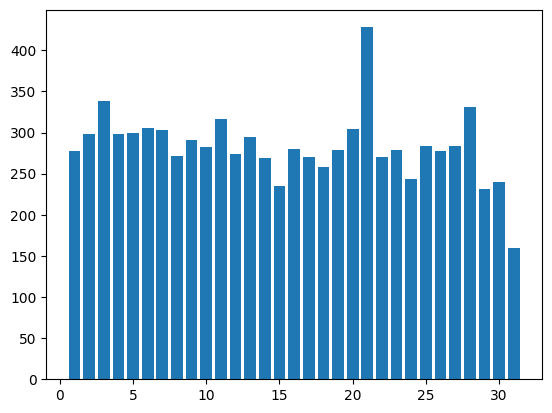

In [41]:
#We see that, in general, the sales are homogenously distributed around all days in a month. There is
#still the curious spike at the 21st; maybe this is the day of the salary payment and that is why more
#people buy that day. 

plt.bar(range(1,32),ord_created_at_date_separated.groupby(['Day'])['Month'].count())

<BarContainer object of 24 artists>

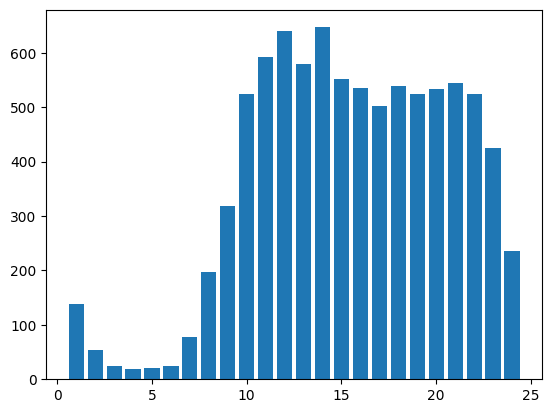

In [42]:
#By plotting when the orders are created, we clearly see how they are distributed approximately 
#equally around the day, and not at night, implying that we work only in one timezone. In addition, this 
#distribution gives no apparent reason why at 10.00 there should be more cancellations that any other hours.
#For this, we could investigate if it was during a punctual day, and if it did not happen during a specific 
#day then we might know when is the best moment of the day to launch a discount, or some kind of action for
#our basket not to be cancelled. 

plt.bar(range(1,25),ord_created_at_date_separated.groupby(['Hour'])['Month'].count())

In [ ]:
#order_date: apparently, a reduction of the column of created_at, including only the date of succesful basket
#creation.


In [55]:
#user_order_seq: it can be kind of predicted that this value corresponds to the what n order is the one
#for a user. So, for someone that has not bought anything before, he will have a 1 on their first purchase.
#If they buy again, the user_order_seq will be 2, and so on. We can check this by isolating, for example,
#the 2 users that most things bought.

user_id_mostcommon=user_id_counter.most_common(2)
user_id_mostcommon


[('ba7176c5f870cd86e51ecc4375e0becc8cc305845e70b9384ba0d4d156c6099ec96602b15420cb1ff69b6b9adcf9249d09489d511565531c4e928a92157b16d6',
  25),
 ('04e9d7967f4dfd7d40175f130f1c80f62204ff697df92dfd83407ace7997b6744b6a7cab0382e60f7264b13ba3f03c64f016ae9dca664885ace6020aba3b5131',
  22)]

In [53]:
#This is confirmed by the most habitual customer, with a total of 25 times. Let's double check it with the
#second most habitual customer.

user_id_mostcommon_df = orders[orders['user_id'] == user_id_mostcommon[0][0]] 
print(user_id_mostcommon_df["user_order_seq"])

16245     1
18494     2
19262     3
19835     4
20762     5
21366     6
21989     7
24028     8
24631     9
25435    10
26361    11
27263    12
28672    13
30703    14
33236    15
36040    16
39746    17
42646    18
45537    19
49073    20
54555    21
57864    22
60099    23
63551    24
63830    25
Name: user_order_seq, dtype: int64


In [56]:
#This is confirmed by the most habitual customer, with a total of 25 times. Let's double check it with the
#second most habitual customer.

user_id_mostcommon_df2 = orders[orders['user_id'] == user_id_mostcommon[1][0]] 
print(user_id_mostcommon_df2["user_order_seq"])

7444      1
8439      2
9008      3
9621      4
10767     5
11694     6
13089     7
14264     8
16466     9
17809    10
18543    11
19986    12
21507    13
22380    14
23463    15
24036    16
25457    17
27382    18
28543    19
30234    20
32725    21
56583    22
Name: user_order_seq, dtype: int64


In [ ]:
#ordered_items: this provides the items bought by each customer. We can analyse many things 
#related to this. 
#to be continued...

In [120]:
print(regulars)
#to be continued...

                                                 user_id      variant_id  \
3      68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...  33618848088196   
11     aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...  33667178659972   
18     68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...  33619009208452   
46     aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...  33667305373828   
47     4594e99557113d5a1c5b59bf31b8704aafe5c7bd180b32...  33667247341700   
...                                                  ...             ...   
37644  20a41b8fa616484b39812aaa377ea1b53247f6941c0586...  39265878999172   
37717  ba068a3398230c10a98868ced1fcc5b889b21e6f112fd0...  39459281272964   
37718  ba068a3398230c10a98868ced1fcc5b889b21e6f112fd0...  33973246951556   
37719  ba068a3398230c10a98868ced1fcc5b889b21e6f112fd0...  39587297656964   
37720  ba068a3398230c10a98868ced1fcc5b889b21e6f112fd0...  34415987753092   

               created_at  
3     2020-04-30 15:07:03  
11    2020-05-05 23:34:35  
18 

In [121]:
print(users)
#to be continued...

                                                user_id user_segment  \
2160  0e823a42e107461379e5b5613b7aa00537a72e1b0eaa7a...       Top Up   
1123  15768ced9bed648f745a7aa566a8895f7a73b9a47c1d4f...       Top Up   
1958  33e0cb6eacea0775e34adbaa2c1dec16b9d6484e6b9324...       Top Up   
675   57ca7591dc79825df0cecc4836a58e6062454555c86c35...       Top Up   
4694  085d8e598139ce6fc9f75d9de97960fa9e1457b409ec00...       Top Up   
...                                                 ...          ...   
3011  2c0eaa81411d8796e4e28a1a13265aa773e815d83e6db1...  Proposition   
4343  bf8da3ba3538396b70564a49f55f26303af645a0fe32fa...       Top Up   
2725  b1892f28d8bb191138ec1f098a8e229c16755f2616aea0...       Top Up   
4340  2745667201081b389e4b290565d17651b3eb94d9077183...  Proposition   
3360  d96aadc220f2776037e519f2c3bd4a2f0199658cc45b29...  Proposition   

     user_nuts1     first_ordered_at customer_cohort_month  count_people  \
2160        UKH  2021-05-08 13:33:49   2021-05-01 00:00:00 

In [ ]:
#Stuff to study:
#- Do the buyers that have abandoned a cart bought another order, or do they never even consider
#buying something again? -> Improvement quality

#Maybe they are people that started the order and never
#finished it. Maybe they are already users that had to cancel an order. Maybe that low number of 
#people with more orders rejected (7 onwards) are habitual clients that as they do many orders they 
#sometimes do errors and have to cancel more often...

#to be continued...